In [1]:
from random import sample
import numpy as np
import pandas as pd 
import os
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(20736, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.relu((self.conv1(x)))
        x = self.pool(x)
        x = self.relu((self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.relu((self.conv3(x)))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        output = self.fc2(x)
        return output
    
    
class ImageDataset(Dataset):

    def __init__(self, df, images_directory, transforms=None):
        self.df = df
        self.directory = images_directory
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name_label = self.df.iloc[idx]['name_label']
        label = self.df.iloc[idx]['label']
        number = self.df.iloc[idx]['number']
        image = Image.open(f"{self.directory}/{name_label}/{number}")
        if self.transforms:
            image = self.transforms(image)
        return image, label


In [3]:
def show(img, title=None):
    img = img.detach()
    img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(np.asarray(img))
    if title:
        plt.title(title)
    plt.show()
    
    
def show_from_df(df, x, y):
    df = df.sample(x*y)
    images = []
    to_tensor = torchvision.transforms.ToTensor()
    for idx, row in df.iterrows():
        image = Image.open(f"data/{row['name_label']}/{row['number']}")
        image = torchvision.transforms.Resize((150, 150))(image)
        image = to_tensor(image)
        images.append(image)
    grid = torchvision.utils.make_grid(images, nrow=x, padding=3)
    show(grid)
    
    
def compare_show(df):       
    for idx, row in df.iterrows():
        image = Image.open(f"data/{row['name_label']}/{row['number']}")
        image = torchvision.transforms.Resize((150, 150))(image)
        plt.imshow(np.asarray(image))
        plt.title(f'''Label: {row['name_label']} \nMy model: {labels_dict[row['my_model_predicted']]} \nResnet50: {labels_dict[row['resnet50_predicted']]}''')
        plt.show()
        

def df_prediction(row, model):
    image = Image.open(f"data/{row['name_label']}/{row['number']}")
    image = torchvision.transforms.Resize((150, 150))(image)
    image = torchvision.transforms.ToTensor()(image)
    image = image.view([1,3,150,150]).to(device)
    prediction = model(image)
    prediction = torch.argmax(prediction, dim=1)
    return int(prediction)


def printTestAccuracy(model, test_dataloader):
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted = model.predict(images)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print(f"Test accuracy: {accuracy:.3f}")

    
def printTestReport(model, test_dataloader):
    all_labels = torch.tensor([]).to(device)
    all_predicted = torch.tensor([]).to(device)
    target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            predicted = torch.argmax(predicted, dim=1)
            all_labels = torch.concat([all_labels, labels])
            all_predicted = torch.concat([all_predicted, predicted])
    print(classification_report(all_labels.cpu(), all_predicted.cpu(), target_names=target_names))    


def training(model, max_epochs, patience, save_path, train_dataloader, validation_dataloader, test_dataloader):
    train_losses = []
    valid_losses = []
    counter = 0
    best_model_dict = {}
    best_val_loss = 99

    for epoch in range(1, max_epochs+1):
        # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
        # training-the-model
        model.train()
        for data, target in train_dataloader:
            # move-tensors-to-GPU 
            data = data.to(device)
            target = target.to(device)
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            # calculate-the-batch-loss
            loss = criterion(output, target)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-ingle-optimization-step (parameter-update)
            optimizer.step()
            # update-training-loss
            train_loss += loss.item() * data.size(0)

        # validate-the-model
        model.eval()
        for data, target in validation_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)

        # calculate-average-losses
        train_loss = train_loss/len(train_dataloader.sampler)
        valid_loss = valid_loss/len(validation_dataloader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # print-training/validation-statistics 
        print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.3f} \tValidation Loss: {valid_loss:.3f}")

        # Early stopping
        if valid_loss < best_val_loss:
            counter = 0
            best_val_loss = valid_loss
            best_model_dict = model.state_dict()
            best_epoch = epoch
        else:
            counter += 1
            if counter > patience:
                model.load_state_dict(best_model_dict)
                torch.save(model, save_path)
                break
    print("Finished training")

    plt.axvline(best_epoch-1, linestyle='--', color='r',label='Early Stopping')
    plt.plot(train_losses, label='training loss')
    plt.plot(valid_losses, label='validation loss')
    plt.title('Training')
    plt.legend()
    plt.show()
    
    # Classification report on test set
    printTestReport(model, test_dataloader)
    
    return model

In [4]:
# GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Loading the data

In [5]:
# Creating labels and splitting data
buildings = pd.DataFrame(os.listdir('data/buildings'), columns=['number'])
forest = pd.DataFrame(os.listdir('data/forest'), columns=['number'])
glacier = pd.DataFrame(os.listdir('data/glacier'), columns=['number'])
mountain = pd.DataFrame(os.listdir('data/mountain'), columns=['number'])
sea = pd.DataFrame(os.listdir('data/sea'), columns=['number'])
street = pd.DataFrame(os.listdir('data/street'), columns=['number'])

buildings['name_label'] = 'buildings'
forest['name_label'] = 'forest'
glacier['name_label'] = 'glacier'
mountain['name_label'] = 'mountain'
sea['name_label'] = 'sea'
street['name_label'] = 'street'

print(f"""Number of images per class: \nbuildings: {len(buildings)} \nforest: {len(forest)}
glacier: {len(glacier)} \nmountain: {len(mountain)} \nsea: {(len(sea))} \nstreet: {len(street)}""")

labels_dict = {
    'buildings':0,
    'forest':1,
    'glacier':2,
    'mountain':3,
    'sea':4,
    'street':5,
    0:'buildings',
    1:'forest',
    2:'glacier',
    3:'mountain',
    4:'sea',
    5:'street'    
}

buildings['label'] = buildings['name_label'].apply(lambda name: labels_dict[name])
forest['label'] = forest['name_label'].apply(lambda name: labels_dict[name])
glacier['label'] = glacier['name_label'].apply(lambda name: labels_dict[name])
mountain['label'] = mountain['name_label'].apply(lambda name: labels_dict[name])
sea['label'] = sea['name_label'].apply(lambda name: labels_dict[name])
street['label'] = street['name_label'].apply(lambda name: labels_dict[name])

i,j = 2000, 2300
train = pd.concat([buildings[:i], forest[:i], glacier[:i], mountain[:i], sea[:i], street[:i]])
valid = pd.concat([buildings[i:j], forest[i:j], glacier[i:j], mountain[i:j], sea[i:j], street[i:j]])
test = pd.concat([buildings[j:], forest[j:], glacier[j:], mountain[j:], sea[j:], street[j:]])
display(train)

Number of images per class: 
buildings: 2600 
forest: 2600
glacier: 2600 
mountain: 2600 
sea: 2600 
street: 2600


,number,name_label,label
0,0.jpg,buildings,0
1,10006.jpg,buildings,0
2,1001.jpg,buildings,0
3,10014.jpg,buildings,0
4,10018.jpg,buildings,0
...,...,...,...
1995,532.jpg,street,5
1996,5321.jpg,street,5
1997,5329.jpg,street,5
1998,5332.jpg,street,5


buildings - pictures


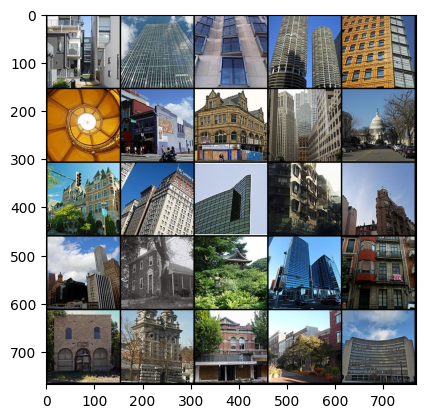

In [6]:
print('buildings - pictures')
show_from_df(buildings[:i], 5, 5)

forest - pictures


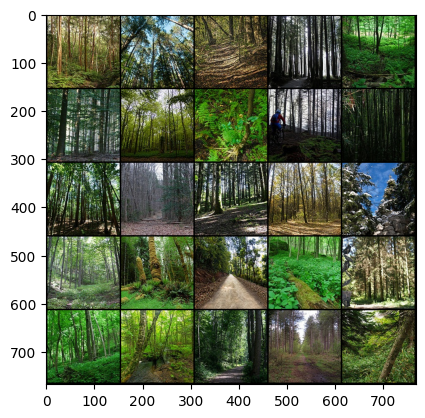

In [7]:
print('forest - pictures')
show_from_df(forest[:i], 5, 5)

glacier - pictures


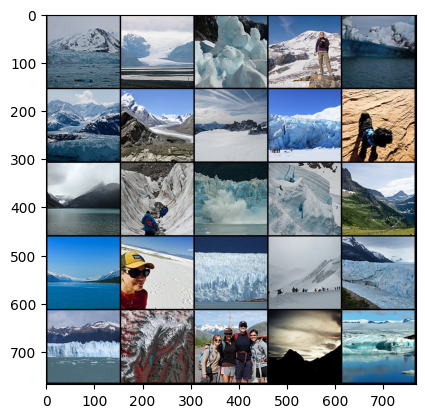

In [8]:
print('glacier - pictures')
show_from_df(glacier[:i], 5, 5)

mountain - pictures


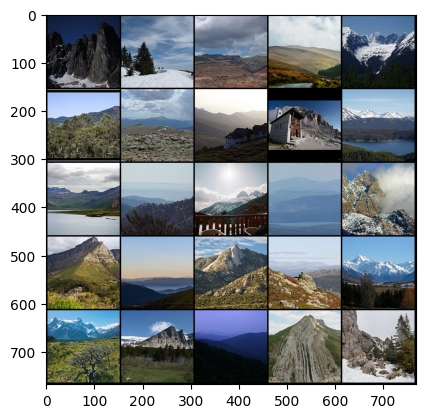

In [9]:
print('mountain - pictures')
show_from_df(mountain[:i], 5, 5)

sea - pictures


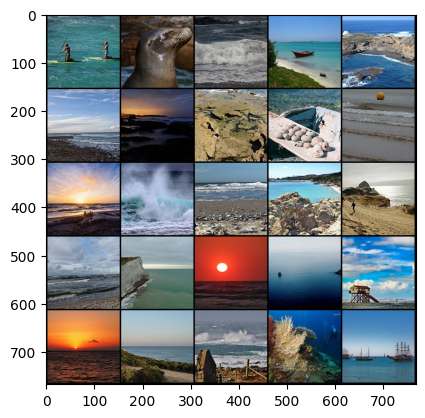

In [10]:
print('sea - pictures')
show_from_df(sea[:i], 5, 5)

street - pictures


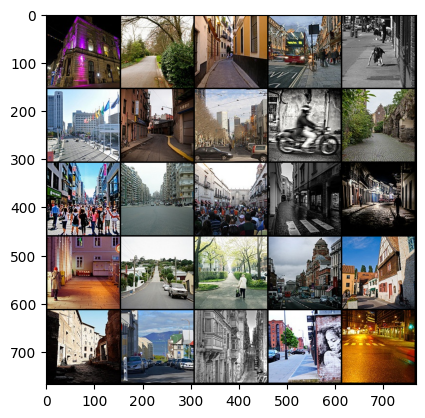

In [11]:
print('street - pictures')
show_from_df(street[:i], 5, 5)

### Mean and std across channels

In [5]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((150, 150)), torchvision.transforms.ToTensor()])
train_dataset = ImageDataset(train, 'data', transforms)
dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

no_of_images = 0
mean = 0.
std = 0.
for batch in dl:
    batch = batch[0]
    # Rearrange batch to be the shape of [batch_size, no_of_channels, width_of_image * height_of_image]
    batch = batch.view(batch.size(0), batch.size(1), -1) 
    # Update total number of images
    no_of_images += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
    
mean /= no_of_images
std /= no_of_images

print(f"Mean of images across channels: {mean} \nStandard deviation of images across channels: {std}")

Mean of images across channels: tensor([0.4296, 0.4559, 0.4517]) 
Standard deviation of images across channels: tensor([0.2356, 0.2344, 0.2424])


In [12]:
train_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((150, 150)), 
                                                   torchvision.transforms.RandomHorizontalFlip(),
                                                   torchvision.transforms.RandomVerticalFlip(0.2),
                                                   torchvision.transforms.ToTensor(), 
                                                   #torchvision.transforms.Normalize(mean, std)
                                                  ])
test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((150, 150)), 
                                                  torchvision.transforms.ToTensor(), 
                                                  #torchvision.transforms.Normalize(mean, std)
                                                 ])

train_dataset = ImageDataset(train, 'data', train_transforms)
validation_dataset = ImageDataset(valid, 'data', test_transforms)
test_dataset = ImageDataset(test, 'data', test_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=0)

# Train models

### My model - training and evaluation

Epoch: 1 	Training Loss: 1.049 	Validation Loss: 0.766
Epoch: 2 	Training Loss: 0.743 	Validation Loss: 0.608
Epoch: 3 	Training Loss: 0.612 	Validation Loss: 0.544
Epoch: 4 	Training Loss: 0.528 	Validation Loss: 0.512
Epoch: 5 	Training Loss: 0.483 	Validation Loss: 0.531
Epoch: 6 	Training Loss: 0.411 	Validation Loss: 0.509
Epoch: 7 	Training Loss: 0.376 	Validation Loss: 0.463
Epoch: 8 	Training Loss: 0.336 	Validation Loss: 0.461
Epoch: 9 	Training Loss: 0.298 	Validation Loss: 0.521
Epoch: 10 	Training Loss: 0.275 	Validation Loss: 0.589
Epoch: 11 	Training Loss: 0.238 	Validation Loss: 0.548
Epoch: 12 	Training Loss: 0.222 	Validation Loss: 0.593
Epoch: 13 	Training Loss: 0.198 	Validation Loss: 0.614
Epoch: 14 	Training Loss: 0.175 	Validation Loss: 0.696
Finished training


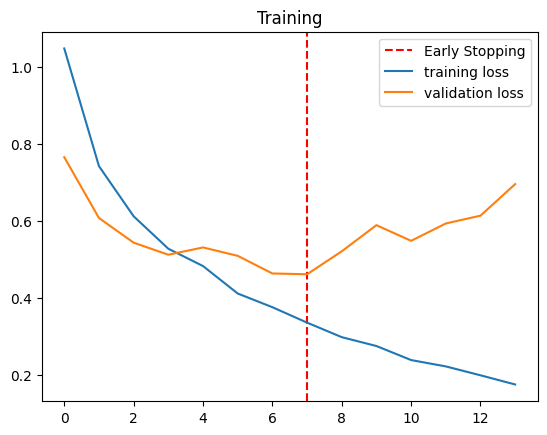

              precision    recall  f1-score   support

   buildings       0.84      0.78      0.81       300
      forest       0.85      0.98      0.91       300
     glacier       0.81      0.75      0.78       300
    mountain       0.75      0.82      0.79       300
         sea       0.89      0.83      0.86       300
      street       0.81      0.79      0.80       300

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800



In [13]:
# My model
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

my_model = training(model, 50, 5, 'saved_models/my_model', train_dataloader, validation_dataloader, test_dataloader)

### Resnet50 - training and evaluation

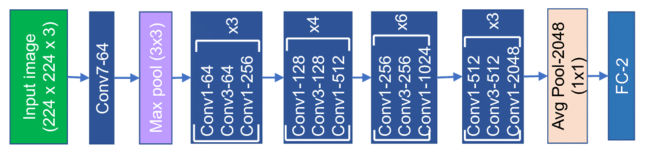

Epoch: 1 	Training Loss: 0.497 	Validation Loss: 0.303
Epoch: 2 	Training Loss: 0.348 	Validation Loss: 0.287
Epoch: 3 	Training Loss: 0.314 	Validation Loss: 0.274
Epoch: 4 	Training Loss: 0.298 	Validation Loss: 0.287
Epoch: 5 	Training Loss: 0.295 	Validation Loss: 0.270
Epoch: 6 	Training Loss: 0.291 	Validation Loss: 0.271
Epoch: 7 	Training Loss: 0.274 	Validation Loss: 0.269
Epoch: 8 	Training Loss: 0.272 	Validation Loss: 0.270
Epoch: 9 	Training Loss: 0.271 	Validation Loss: 0.262
Epoch: 10 	Training Loss: 0.268 	Validation Loss: 0.265
Epoch: 11 	Training Loss: 0.264 	Validation Loss: 0.283
Epoch: 12 	Training Loss: 0.265 	Validation Loss: 0.264
Epoch: 13 	Training Loss: 0.270 	Validation Loss: 0.279
Epoch: 14 	Training Loss: 0.264 	Validation Loss: 0.284
Epoch: 15 	Training Loss: 0.251 	Validation Loss: 0.281
Finished training


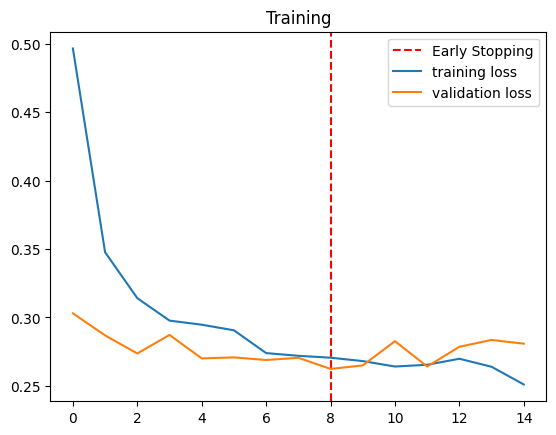

              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       300
      forest       0.97      0.98      0.97       300
     glacier       0.92      0.77      0.84       300
    mountain       0.81      0.89      0.85       300
         sea       0.92      0.97      0.94       300
      street       0.93      0.92      0.92       300

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [8]:
# Resnet50
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False
num_features= model.fc.in_features
model.fc = nn.Linear(num_features, 6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

resnet50 = training(model, 50, 5, 'saved_models/resnet50', train_dataloader, validation_dataloader, test_dataloader)

### VGG19 - training and evaluation

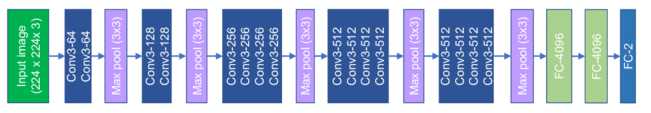

Epoch: 1 	Training Loss: 0.519 	Validation Loss: 0.385
Epoch: 2 	Training Loss: 0.481 	Validation Loss: 0.388
Epoch: 3 	Training Loss: 0.478 	Validation Loss: 0.369
Epoch: 4 	Training Loss: 0.479 	Validation Loss: 0.366
Epoch: 5 	Training Loss: 0.498 	Validation Loss: 0.420
Epoch: 6 	Training Loss: 0.478 	Validation Loss: 0.451
Epoch: 7 	Training Loss: 0.506 	Validation Loss: 0.393
Epoch: 8 	Training Loss: 0.518 	Validation Loss: 0.420
Epoch: 9 	Training Loss: 0.503 	Validation Loss: 0.376
Epoch: 10 	Training Loss: 0.514 	Validation Loss: 0.373
Finished training


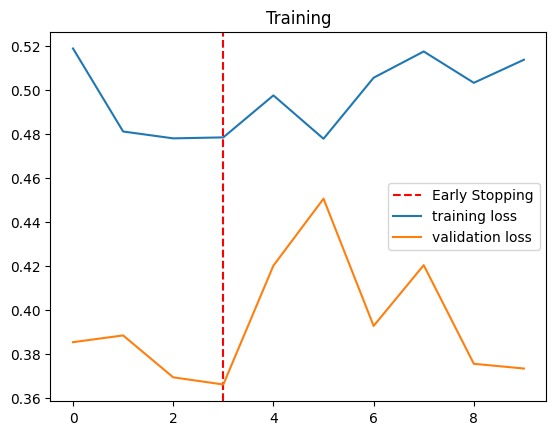

              precision    recall  f1-score   support

   buildings       0.90      0.90      0.90       300
      forest       0.97      0.99      0.98       300
     glacier       0.78      0.85      0.81       300
    mountain       0.84      0.76      0.80       300
         sea       0.96      0.94      0.95       300
      street       0.90      0.90      0.90       300

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



In [9]:
# VGG19
model = models.vgg19(weights='VGG19_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False
num_features= model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 6)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.001)

vgg19 = training(model, 50, 5, 'saved_models/vgg19', train_dataloader, validation_dataloader, test_dataloader)

# Load pretrained models

In [19]:
my_model = torch.load('saved_models/my_model')
printTestReport(my_model, test_dataloader)

              precision    recall  f1-score   support

   buildings       0.84      0.78      0.81       300
      forest       0.85      0.98      0.91       300
     glacier       0.81      0.75      0.78       300
    mountain       0.75      0.82      0.79       300
         sea       0.89      0.83      0.86       300
      street       0.81      0.79      0.80       300

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800



In [20]:
resnet50 = torch.load('saved_models/resnet50')
printTestReport(resnet50, test_dataloader)

              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       300
      forest       0.97      0.98      0.97       300
     glacier       0.92      0.77      0.84       300
    mountain       0.81      0.89      0.85       300
         sea       0.92      0.97      0.94       300
      street       0.93      0.92      0.92       300

    accuracy                           0.91      1800
   macro avg       0.91      0.91      0.91      1800
weighted avg       0.91      0.91      0.91      1800



In [21]:
vgg19 = torch.load('saved_models/vgg19')
printTestReport(vgg19, test_dataloader)

              precision    recall  f1-score   support

   buildings       0.90      0.90      0.90       300
      forest       0.97      0.99      0.98       300
     glacier       0.78      0.85      0.81       300
    mountain       0.84      0.76      0.80       300
         sea       0.96      0.94      0.95       300
      street       0.90      0.90      0.90       300

    accuracy                           0.89      1800
   macro avg       0.89      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800



### Compare models

In [22]:
test['resnet50_predicted'] = test.apply(lambda row: df_prediction(row, resnet50), axis=1)
test['vgg19_predicted'] = test.apply(lambda row: df_prediction(row, vgg19), axis=1)
test['my_model_predicted'] = test.apply(lambda row: df_prediction(row, my_model), axis=1)

test.reset_index(drop=True, inplace=True)
test.to_pickle('summary.pickle')
test

,number,name_label,label,resnet50_predicted,vgg19_predicted,my_model_predicted
0,7491.jpg,buildings,0,0,0,5
1,7493.jpg,buildings,0,0,0,0
2,7496.jpg,buildings,0,0,0,0
3,7498.jpg,buildings,0,0,0,0
4,7501.jpg,buildings,0,0,5,0
...,...,...,...,...,...,...
1795,9961.jpg,street,5,5,5,5
1796,9967.jpg,street,5,5,5,5
1797,9978.jpg,street,5,5,5,5
1798,9989.jpg,street,5,5,5,5


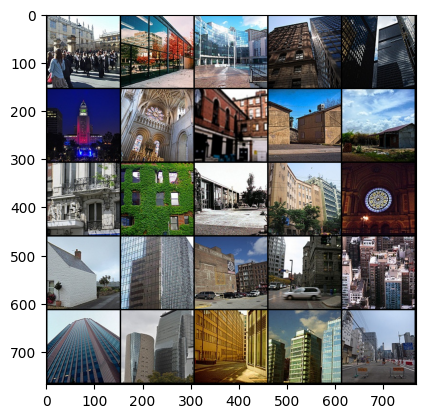

In [23]:
df = test[(test['name_label'] == 'buildings')&(test['my_model_predicted'] != labels_dict['buildings'])]
show_from_df(df, 5, 5)